In [1]:
import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt
from AmortizedMixture import *
from helpers import *

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
NUM_STATES = 2
def prior_fun(num_states=NUM_STATES):
    return {
        'class_probabilities': np.random.dirichlet([1 for _ in range(num_states)]),
        'class_parameters': np.sort(np.random.normal(size=num_states, scale=2))
    }

prior = bf.simulation.Prior(prior_fun = prior_fun)

In [3]:
def simulator_fun(params, num_obs=100, num_states=NUM_STATES):
    pi, mu = params.values()
    z = np.random.choice(a = [i for i in range(num_states)], size = num_obs, replace = True, p=pi)
    loc = mu[z]
    y = np.random.normal(loc=loc, size=(num_obs))
    return {
        "latents": z,
        "observables": y
    }
simulator = bf.simulation.Simulator(simulator_fun=simulator_fun)

In [4]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
NUM_STATES=2

amortizer = AmortizedMixture(
    inference_net=IndependentClassificator(num_outputs=NUM_STATES),
    local_summary_net  = bf.networks.DeepSet(summary_dim=1),
    global_summary_net = bf.networks.DeepSet(summary_dim=10)
)
amortizer.is_conditional

False

In [6]:
def configurator(input_dict):
    parameters = np.array([np.concatenate([a['class_parameters'], a['class_probabilities']]) for a in input_dict['prior_draws']]).astype(np.float32)
    
    latents = [a['latents'] for a in input_dict['sim_data']]
    latents = tf.one_hot(np.array(latents), NUM_STATES)

    observables = np.array([a['observables'] for a in input_dict['sim_data']])[..., np.newaxis, np.newaxis]

    return {
        "parameters": parameters,
        "latents": latents,
        "observables": observables
    }

In [7]:
d = model(3)
cd = configurator(d)
cd['observables'].shape
amortizer.compute_loss(cd)

<tf.Tensor: shape=(), dtype=float32, numpy=34.32385>

In [8]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=configurator)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [9]:
%%time
h = trainer.train_online(epochs=20, iterations_per_epoch=500, batch_size=64)

Training epoch 20: 100%|██████████| 500/500 [00:24<00:00, 20.42it/s, Epoch: 20, Iter: 500,Loss: 21.493,Avg.Loss: 19.521,LR: 1.49E-11]

CPU times: user 19min 48s, sys: 11min 22s, total: 31min 10s
Wall time: 8min 40s


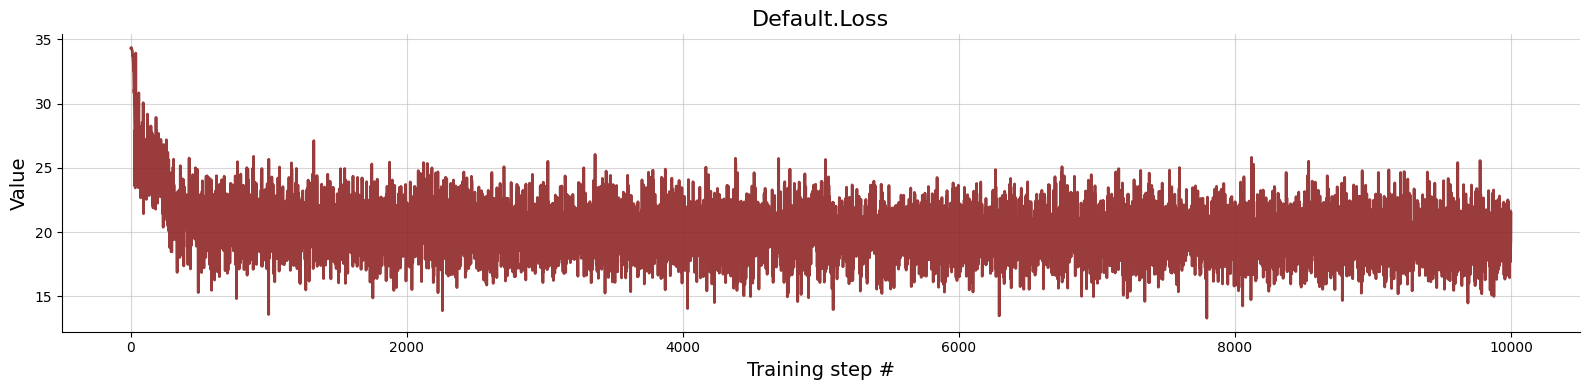

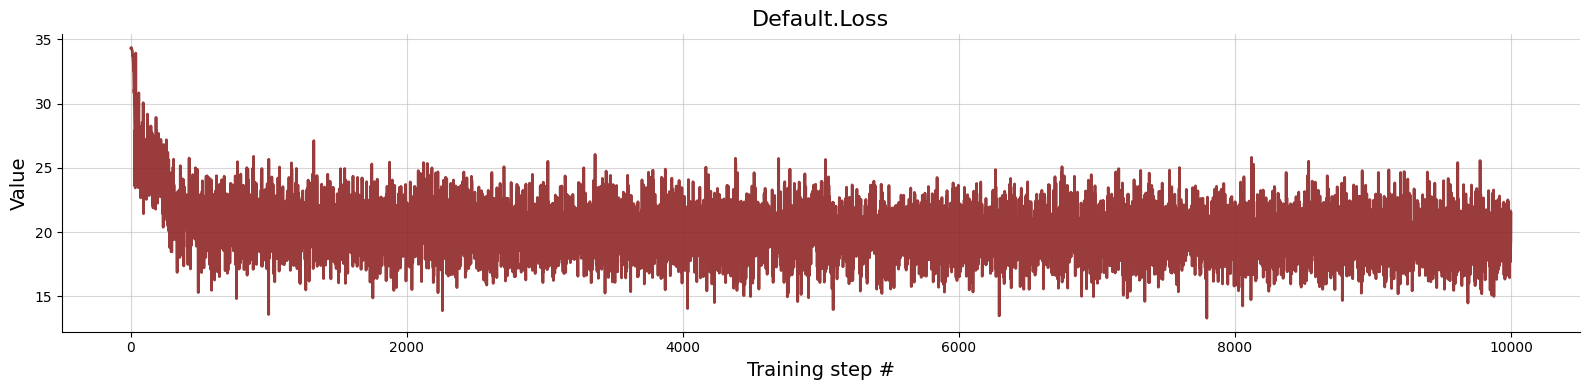

In [11]:
bf.diagnostics.plot_losses(h)

In [23]:
d = model(1)
cd = configurator(d)

In [24]:
p = amortizer.posterior_probs(cd)
classification_entropy(p)    

array([0.59279025], dtype=float32)

In [25]:
def accuracy(p, latents):
    cls = tf.one_hot(np.argmax(p, axis=-1), p.shape[-1])
    acc = np.mean(latents == cls, axis=1)
    return acc

np.mean(accuracy(p, cd['latents']), axis=1)


array([0.88])

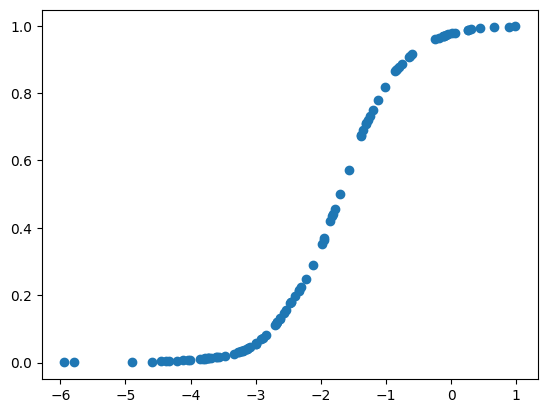

In [26]:
plt.scatter(cd['observables'][0, :, 0, 0], p[0,:,1])

## Amortized mixture posterior

Estimating $p(s, \theta \mid y) = p(s \mid \theta, y) \cdot p(\theta \mid y)$

In [15]:
mixture_net = IndependentClassificator(num_outputs=2)
posterior_net = bf.networks.InvertibleNetwork(num_params=NUM_STATES*2)

local_summary_net = bf.networks.DeepSet(summary_dim=1)
global_summary_net = bf.networks.DeepSet(summary_dim=NUM_STATES*2*2)

amortized_mixture = AmortizedMixture(
    inference_net=mixture_net,
    local_summary_net=local_summary_net
)
amortized_posterior = bf.amortizers.AmortizedPosterior(
    inference_net=posterior_net, 
    summary_net=bf.networks.HierarchicalNetwork([local_summary_net, global_summary_net])
)

amortized_mixture_posterior = AmortizedMixturePosterior(
    amortized_mixture=amortized_mixture, 
    amortized_posterior=amortized_posterior
)

In [16]:
def configurator_mixture_posterior(input_dict):
    mixture_inputs = configurator(input_dict)
    posterior_inputs = {
        'parameters': mixture_inputs['parameters'],
        'summary_conditions': mixture_inputs['observables']
    }

    return {
        'mixture_inputs': mixture_inputs,
        'posterior_inputs': posterior_inputs
    }

In [17]:
d = model(3)
cd = configurator_mixture_posterior(d)

In [18]:
amortized_mixture_posterior.compute_loss(cd)

{'Mix.Loss': <tf.Tensor: shape=(), dtype=float32, numpy=33.840084>,
 'Post.Loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.347837>}

In [19]:
trainer = bf.trainers.Trainer(amortizer=amortized_mixture_posterior, generative_model=model, configurator=configurator_mixture_posterior)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [20]:
%%time
h = trainer.train_online(epochs=20, iterations_per_epoch=500, batch_size=64)

Training epoch 20: 100%|██████████| 500/500 [00:29<00:00, 17.14it/s, Epoch: 20, Iter: 500,Mix.Loss: 16.773,Post.Loss: -4.231,W.Decay: 0.227,Avg.Mix.Loss: 13.337,Avg.Post.Loss: -4.442,Avg.W.Decay: 0.227,LR: 1.49E-11]


CPU times: user 31min 3s, sys: 13min 48s, total: 44min 51s
Wall time: 10min 6s


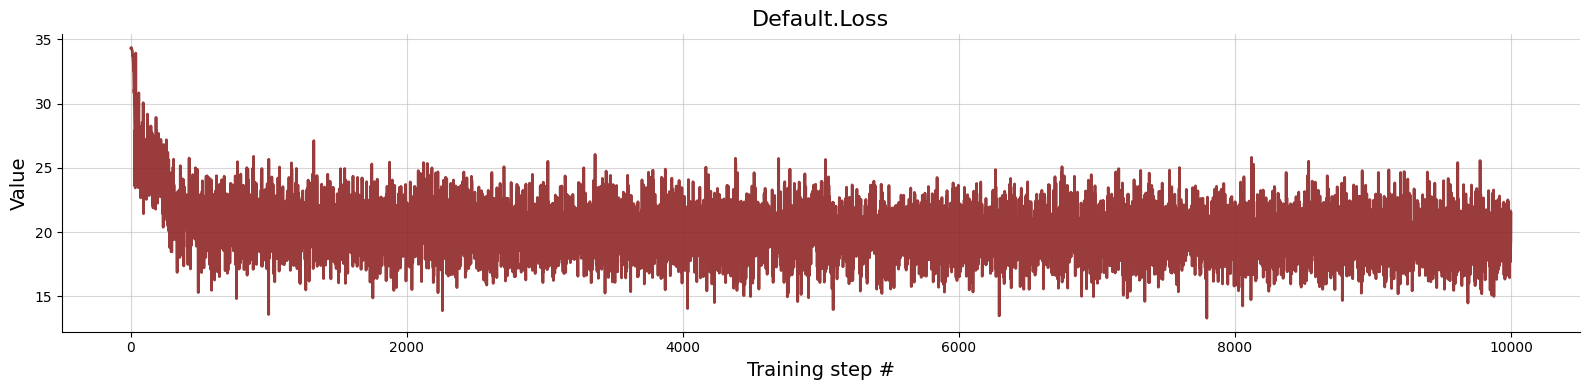

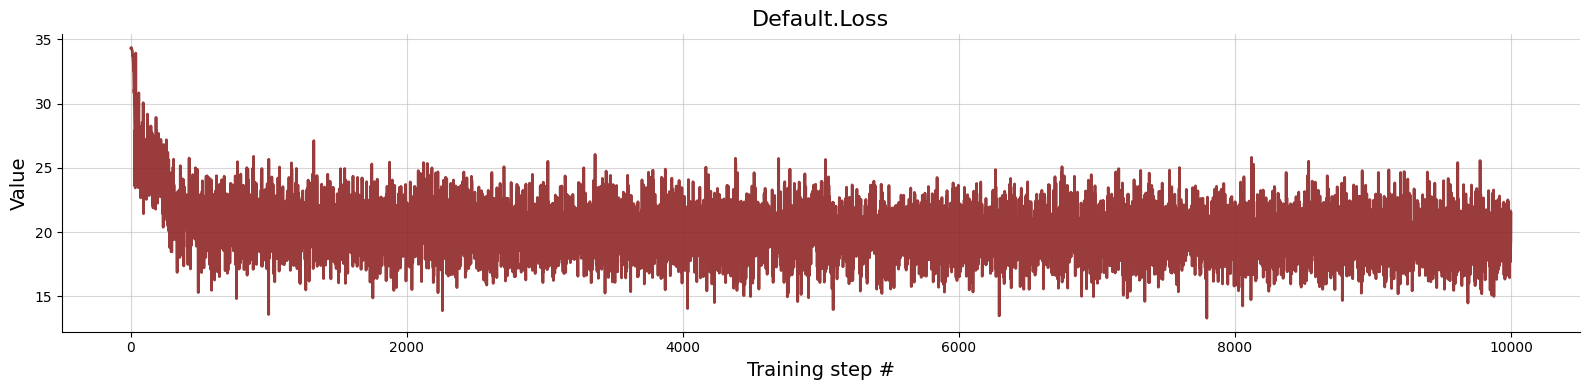

In [10]:
bf.diagnostics.plot_losses(h)

In [66]:
df = model(1)
df_conf = configurator_mixture_posterior(df)
parameter_estimates, mixture_estimates = amortized_mixture_posterior.sample(df_conf, n_samples=1000, to_numpy=False)
mixture_estimates = np.array(mixture_estimates)
mixture_estimates_simple = amortizer(df_conf['mixture_inputs'])
mixture_estimates_simple = np.array(mixture_estimates_simple)

In [86]:
x = np.array(df_conf['mixture_inputs']['observables'][0, :, 0, 0])
ind = np.argsort(x)
x = x[ind]
p = mixture_estimates[0,:,ind,1]
p_simple = mixture_estimates_simple[0,ind,1]

(100, 1000)

Text(0, 0.5, 'P(S = 1)')

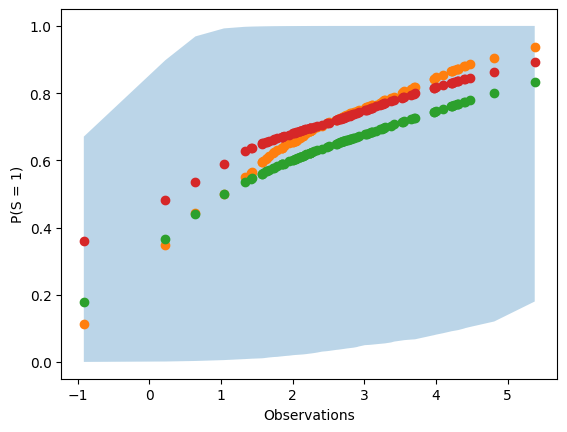

In [88]:
plt.fill_between(
    x, 
    np.quantile(p, q=0.05, axis=1), 
    np.quantile(p, q=0.95, axis=1), 
    alpha=0.3)
plt.scatter(x, np.median(p, axis=1))
plt.scatter(x, np.mean(p, axis=1))
plt.scatter(x, p_simple)
plt.xlabel("Observations")
plt.ylabel("P(S = 1)")